In [1]:
from math import ceil
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv(
    "data/2022/Divvy_Trips_2022_full.csv.gz",
    compression="gzip",
    parse_dates=["started_at", "ended_at"],
)

In [3]:
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,C2F7DD78E82EC875,electric_bike,2022-01-13 11:59:47,2022-01-13 12:02:44,Glenwood Ave & Touhy Ave,525,Clark St & Touhy Ave,RP-007,42.012800,-87.665906,42.012560,-87.674367,casual
1,A6CF8980A652D272,electric_bike,2022-01-10 08:41:56,2022-01-10 08:46:17,Glenwood Ave & Touhy Ave,525,Clark St & Touhy Ave,RP-007,42.012763,-87.665967,42.012560,-87.674367,casual
2,BD0F91DFF741C66D,classic_bike,2022-01-25 04:53:40,2022-01-25 04:58:01,Sheffield Ave & Fullerton Ave,TA1306000016,Greenview Ave & Fullerton Ave,TA1307000001,41.925602,-87.653708,41.925330,-87.665800,member
3,CBB80ED419105406,classic_bike,2022-01-04 00:18:04,2022-01-04 00:33:00,Clark St & Bryn Mawr Ave,KA1504000151,Paulina St & Montrose Ave,TA1309000021,41.983593,-87.669154,41.961507,-87.671387,casual
4,DDC963BFDDA51EEA,classic_bike,2022-01-20 01:31:10,2022-01-20 01:37:12,Michigan Ave & Jackson Blvd,TA1309000002,State St & Randolph St,TA1305000029,41.877850,-87.624080,41.884621,-87.627834,member


In [4]:
# Фильтруем датасет: строчки с началом позже конца и с пустыми значениями начала/конца не нужны
df = df[df["started_at"] < df["ended_at"]]
df = df.dropna(subset=["started_at", "ended_at"])

In [5]:
# Создаем датасеты с началами и концами поездок и соответственно присваиваем значения
start_time = pd.DataFrame(df["started_at"])
start_time["result"] = 1

end_time = pd.DataFrame(df["ended_at"])
end_time["result"] = -1

In [6]:
# Меняем названия колонок, чтобы склеить в один датасет
start_time = start_time.rename(columns={"started_at": "time"})
end_time = end_time.rename(columns={"ended_at": "time"})

df = pd.concat([end_time, start_time])

In [7]:
# Сортируем значения по времени
df = df.sort_values(by=["time"])

In [8]:
# Создаем поле дня, часа и дня-часа
df["day"] = df["time"].dt.date.astype(str)
df["hour"] = df["time"].dt.hour.astype(str)
df["day_hour"] = df["day"] + " " + df["hour"]

# Переводим час к цифровому типу чтобы не ломать сортировку позже
df["hour"] = df["hour"].astype(int)

In [9]:
df.head()

,time,result,day,hour,day_hour
73479,2022-01-01 00:00:05,1,2022-01-01,0,2022-01-01 0
68510,2022-01-01 00:01:00,1,2022-01-01,0,2022-01-01 0
64490,2022-01-01 00:01:16,1,2022-01-01,0,2022-01-01 0
73479,2022-01-01 00:01:48,-1,2022-01-01,0,2022-01-01 0
73485,2022-01-01 00:02:14,1,2022-01-01,0,2022-01-01 0


In [10]:
# Группируем по колонке день-час
groped_df = df.groupby("day_hour", group_keys=True).apply(lambda x: x)

In [11]:
# Создаем колонку со значениями прошлое значение колонки + значение ['result'], таким образом получаем количество активных поездок
groped_df["sum"] = groped_df["result"].cumsum()

In [12]:
# Убираем ненужную колонку result для экономии памяти
groped_df.drop(columns=["result"], inplace=True)

In [13]:
# Переводим день в формат даты
groped_df["day"] = pd.to_datetime(groped_df["day"])

In [14]:
# Создаем сводную таблицу, получаем максимальную нагрузку за каждый час по дням
table = pd.pivot_table(
    groped_df, values="sum", index="day", columns="hour", aggfunc=np.max
)

In [15]:
table.head()

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
day,,,,,,,,,,,,,,,,,,,,,
2022-01-01,68.0,99.0,61.0,12.0,-6.0,-25.0,-20.0,-11.0,-8.0,12.0,...,78.0,75.0,75.0,69.0,68.0,67.0,25.0,26.0,21.0,23.0
2022-01-02,12.0,13.0,18.0,4.0,0.0,2.0,5.0,7.0,20.0,22.0,...,36.0,69.0,56.0,45.0,30.0,23.0,21.0,13.0,11.0,7.0
2022-01-03,17.0,11.0,7.0,-14.0,-13.0,-1.0,10.0,30.0,23.0,23.0,...,26.0,43.0,50.0,64.0,40.0,27.0,6.0,1.0,-3.0,-9.0
2022-01-04,14.0,13.0,23.0,-22.0,-18.0,-3.0,17.0,48.0,52.0,28.0,...,35.0,55.0,76.0,94.0,60.0,48.0,23.0,4.0,-7.0,-12.0
2022-01-05,19.0,20.0,13.0,3.0,5.0,19.0,41.0,50.0,53.0,44.0,...,14.0,27.0,40.0,38.0,38.0,21.0,12.0,2.0,-4.0,1.0


In [16]:
# Посмотрим на графике как менялась максимальная нагрузка по дням за январь
table = table.loc[
    (table.index > datetime(2022, 1, 1)) & (table.index < datetime(2022, 1, 31))
]
table["max_for_day"] = table.max(axis=1)

Text(0.5, 1.0, 'Максимальная нагрузка за день в феврале')

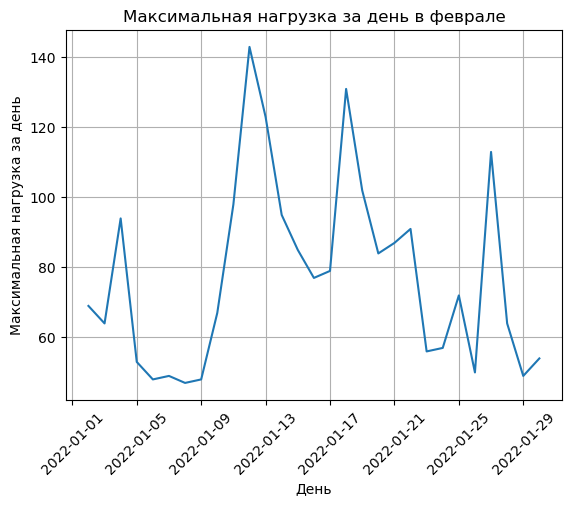

In [17]:
plt.plot(table.index, table["max_for_day"])
plt.xticks(rotation=45)
plt.ylabel("Максимальная нагрузка за день")
plt.xlabel("День")
plt.grid()
plt.title("Максимальная нагрузка за день в феврале")

In [18]:
# Другой тип сводной таблицы - среднее по каждому часу
table = pd.pivot_table(groped_df, values="sum", index=["hour"], aggfunc=np.mean)

In [19]:
table.head()

,sum
hour,
0,206.045620
1,161.745107
2,247.857254
3,0.806433
4,-9.000177


Text(0.5, 1.0, 'Среднее изменение активных поездок в час')

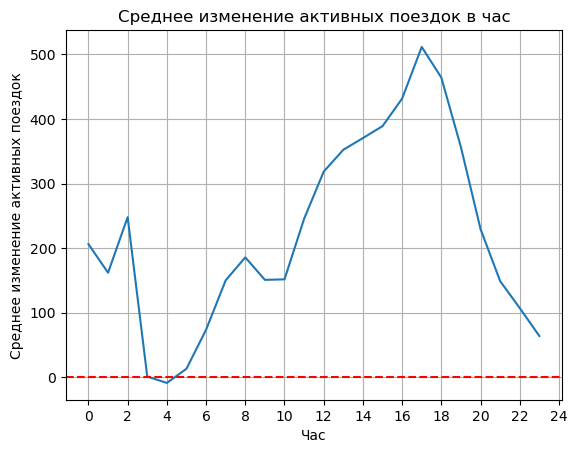

In [20]:
plt.plot(table.index, table.values)
plt.xlabel("Час")
plt.ylabel("Среднее изменение активных поездок")
plt.grid()
plt.axhline(y=0, color="r", linestyle="--")
plt.xticks(range(0, 25, 2))
plt.title("Среднее изменение активных поездок в час")


Теперь можно рассчитать количество велосипедов которые нужны, для того чтобы удовлетворить потребность велосипедов как минимум на 95% в каждый час. Из-за специфики датасета (большая сезонность) проведем такой расчет для каждого из сезонов - весна, лето, осень, зима.

In [21]:
quantiles_list = []

In [22]:
table = pd.pivot_table(
    groped_df, values="sum", index="day", columns="hour", aggfunc=np.max
)

In [23]:
table.head()

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
day,,,,,,,,,,,,,,,,,,,,,
2022-01-01,68.0,99.0,61.0,12.0,-6.0,-25.0,-20.0,-11.0,-8.0,12.0,...,78.0,75.0,75.0,69.0,68.0,67.0,25.0,26.0,21.0,23.0
2022-01-02,12.0,13.0,18.0,4.0,0.0,2.0,5.0,7.0,20.0,22.0,...,36.0,69.0,56.0,45.0,30.0,23.0,21.0,13.0,11.0,7.0
2022-01-03,17.0,11.0,7.0,-14.0,-13.0,-1.0,10.0,30.0,23.0,23.0,...,26.0,43.0,50.0,64.0,40.0,27.0,6.0,1.0,-3.0,-9.0
2022-01-04,14.0,13.0,23.0,-22.0,-18.0,-3.0,17.0,48.0,52.0,28.0,...,35.0,55.0,76.0,94.0,60.0,48.0,23.0,4.0,-7.0,-12.0
2022-01-05,19.0,20.0,13.0,3.0,5.0,19.0,41.0,50.0,53.0,44.0,...,14.0,27.0,40.0,38.0,38.0,21.0,12.0,2.0,-4.0,1.0


In [24]:
winter_df = table.loc[
    ((table.index >= datetime(2022, 1, 1)) & (table.index <= datetime(2022, 2, 28)))
    | ((table.index >= datetime(2022, 12, 1)) & (table.index <= datetime(2022, 12, 31)))
]

In [25]:
winter_df = winter_df.sort_index()

In [26]:
winter_result = winter_df.quantile(q=0.95)

Text(0.5, 1.0, 'Количество велосипедов одновременно в прокате в зимний сезон')

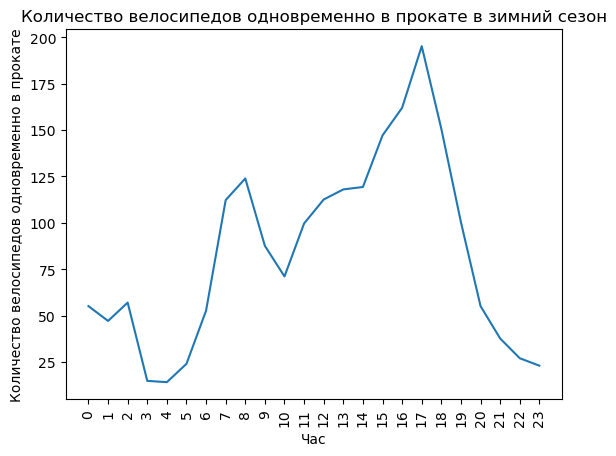

In [27]:
plt.plot(winter_result.index, winter_result.values)
plt.xticks(rotation=90)
plt.xticks(winter_result.index)
plt.xlabel("Час")
plt.ylabel("Количество велосипедов одновременно в прокате")
plt.title("Количество велосипедов одновременно в прокате в зимний сезон")

In [28]:
spring_df = table.loc[
    (table.index >= datetime(2022, 3, 1)) & (table.index <= datetime(2022, 5, 31))
]

In [29]:
spring_df = spring_df.sort_index()

In [30]:
spring_result = spring_df.quantile(q=0.95)

Text(0.5, 1.0, 'Количество велосипедов одновременно в прокате в весенний сезон')

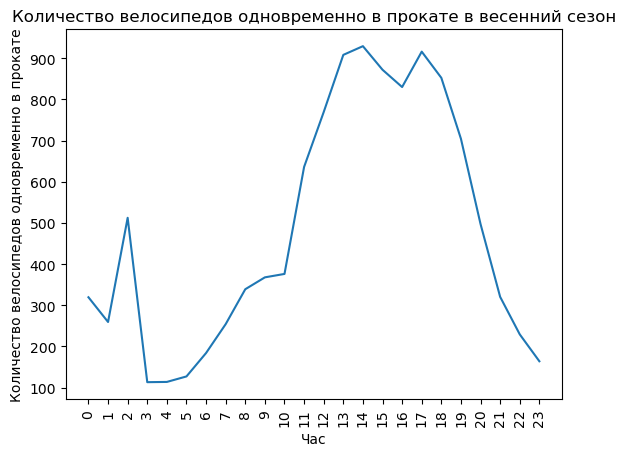

In [31]:
plt.plot(spring_result.index, spring_result.values)
plt.xticks(rotation=90)
plt.xticks(spring_result.index)
plt.xlabel("Час")
plt.ylabel("Количество велосипедов одновременно в прокате")
plt.title("Количество велосипедов одновременно в прокате в весенний сезон")

In [32]:
summer_df = table.loc[
    (table.index >= datetime(2022, 6, 1)) & (table.index <= datetime(2022, 8, 31))
]

In [33]:
summer_df = summer_df.sort_index()

In [34]:
summer_result = summer_df.quantile(q=0.95)

Text(0.5, 1.0, 'Количество велосипедов одновременно в прокате в летний сезон')

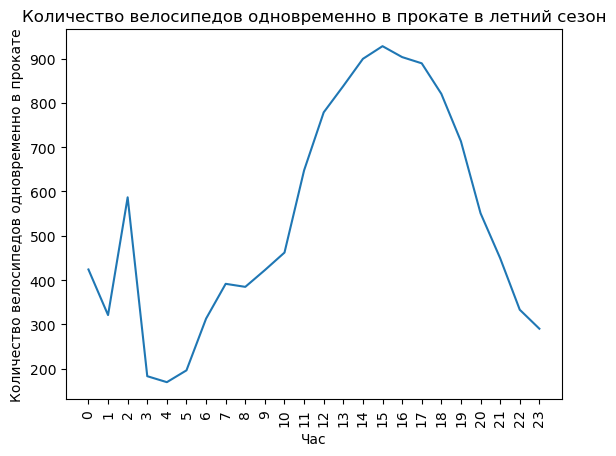

In [35]:
plt.plot(summer_result.index, summer_result.values)
plt.xticks(rotation=90)
plt.xticks(summer_result.index)
plt.xlabel("Час")
plt.ylabel("Количество велосипедов одновременно в прокате")
plt.title("Количество велосипедов одновременно в прокате в летний сезон")

In [36]:
autumn_df = table.loc[
    (table.index >= datetime(2022, 9, 1)) & (table.index <= datetime(2022, 11, 30))
]

In [37]:
autumn_df = autumn_df.sort_index()

In [38]:
autumn_result = autumn_df.quantile(q=0.95)

Text(0.5, 1.0, 'Количество велосипедов одновременно в прокате в осенний сезон')

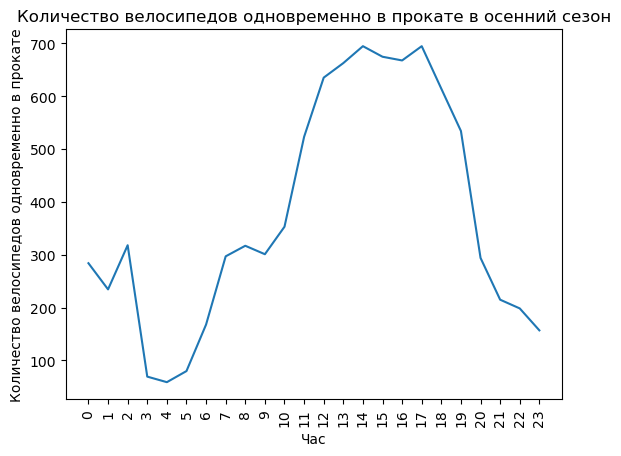

In [39]:
plt.plot(autumn_result.index, autumn_result.values)
plt.xticks(rotation=90)
plt.xticks(autumn_result.index)
plt.xlabel("Час")
plt.ylabel("Количество велосипедов одновременно в прокате")
plt.title("Количество велосипедов одновременно в прокате в осенний сезон")

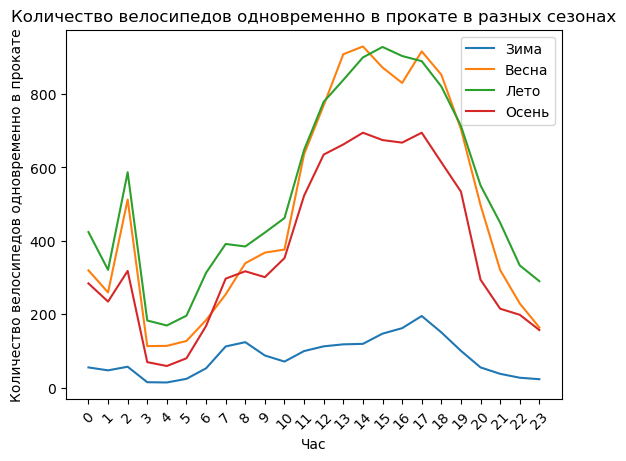

In [40]:
# Создадим общий график
plt.plot(winter_result.index, winter_result.values, label="Зима")
plt.plot(spring_result.index, spring_result.values, label="Весна")
plt.plot(summer_result.index, summer_result.values, label="Лето")
plt.plot(autumn_result.index, autumn_result.values, label="Осень")
plt.xticks(rotation=45)
plt.xticks(winter_result.index)
plt.xlabel("Час")
plt.ylabel("Количество велосипедов одновременно в прокате")
plt.title("Количество велосипедов одновременно в прокате в разных сезонах")
plt.legend()

In [41]:
# Посчитаем общий персентиль для каждого сезона
winter_percentile = winter_result.quantile(q=0.95)
spring_percentile = spring_result.quantile(q=0.95)
summer_percentile = summer_result.quantile(q=0.95)
autumn_percentile = autumn_result.quantile(q=0.95)

mean_percentile = (
    winter_percentile + spring_percentile + summer_percentile + autumn_percentile
) / 4

Text(0.5, 1.0, 'Количество велосипедов одновременно в прокате в разных сезонах')

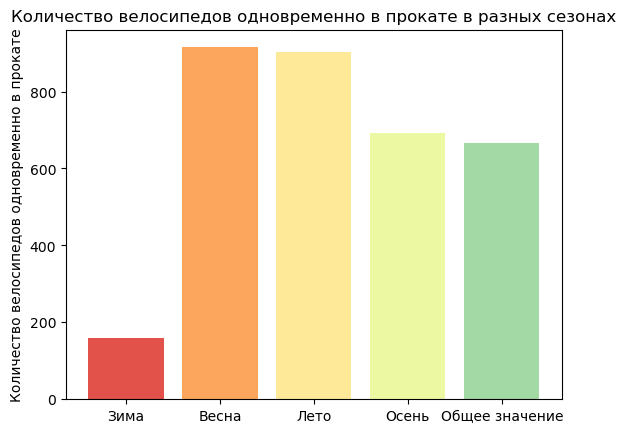

In [42]:
import seaborn as sns

sns.set_palette("Spectral")
colors = sns.color_palette()
plt.bar(
    ["Зима", "Весна", "Лето", "Осень", "Общее значение"],
    [
        winter_percentile,
        spring_percentile,
        summer_percentile,
        autumn_percentile,
        mean_percentile,
    ],
    color=colors,
)
plt.ylabel("Количество велосипедов одновременно в прокате")
plt.title("Количество велосипедов одновременно в прокате в разных сезонах")

In [43]:
# Результаты
print(
    f"Чтобы покрыть потребность велосипедов как минимум на 95% в каждый час в зимний сезон, нужно иметь в прокате как минимум {ceil(winter_percentile)}, велосипедов"
    f" в весенний сезон - {ceil(spring_percentile)}, в летний сезон - {ceil(summer_percentile)}, в осенний сезон - {ceil(autumn_percentile)}, в среднем для всех сезонов - {ceil(mean_percentile)}"
)

Чтобы покрыть потребность велосипедов как минимум на 95% в каждый час в зимний сезон, нужно иметь в прокате как минимум 161, велосипедов в весенний сезон - 915, в летний сезон - 903, в осенний сезон - 692, в среднем для всех сезонов - 668


# Подсчет нагрузки по станциям
Посчитаем похожую метрику для станций. Здесь интересно немного другое значение - какие станции наиболее нагружены, потому что возможно на такие станции нужно довозить велосипеды для поддержания нормального количества велосипедов в прокате.

In [2]:
df = pd.read_csv(
    "data/2022/Divvy_Trips_2022_full.csv.gz",
    compression="gzip",
    parse_dates=["started_at", "ended_at"],
)

In [3]:
# создание нового датафрейма только с нужными столбцами для начала поездки
start_df = df.loc[:, ["started_at", "start_station_name"]]
start_df["result"] = -1
# создание нового датафрейма только с нужными столбцами для конца поездки
end_df = df.loc[:, ["ended_at", "end_station_name"]]
end_df["result"] = 1

In [4]:
# Переименование столбцов для удобства
start_df.rename(
    columns={"started_at": "date", "start_station_name": "station"}, inplace=True
)
end_df.rename(columns={"ended_at": "date", "end_station_name": "station"}, inplace=True)

In [5]:
stations_df = pd.concat([start_df, end_df])

In [6]:
# Сортировка по дате и получение колонки с днем - по ней будем группировать
stations_df = stations_df.sort_values(by="date")
stations_df["day"] = stations_df["date"].dt.date

In [7]:
grouped_df = stations_df.groupby(["day", "station"], group_keys=True).apply(lambda x: x)

In [74]:
grouped_df.head()

date             station_   
day        station                                                              
2022-01-01 2112 W Peterson Ave 13290 2022-01-01 07:19:15  2112 W Peterson Ave  \
                               1527  2022-01-01 20:48:16  2112 W Peterson Ave   
           900 W Harrison St   66752 2022-01-01 01:24:48    900 W Harrison St   
                               67369 2022-01-01 01:25:28    900 W Harrison St   
                               66785 2022-01-01 01:25:35    900 W Harrison St   

                                      result        day_  sum  
day        station                                             
2022-01-01 2112 W Peterson Ave 13290       1  2022-01-01    1  
                               1527       -1  2022-01-01    0  
           900 W Harrison St   66752      -1  2022-01-01   -1  
                               67369      -1  2022-01-01   -2  
                               66785      -1  2022-01-01   -3

In [75]:
grouped_df["sum"] = grouped_df["result"].cumsum()

In [76]:
# Переименование столбцов, для того чтобы убрать дублирующиеся названия
grouped_df.rename(columns={"station": "station_", "day": "day_"}, inplace=True)

In [77]:
table2 = table = pd.pivot_table(
    grouped_df, values="sum", index=["day", "station"], aggfunc=np.median
)

In [78]:
table = pd.pivot_table(
    grouped_df,
    values="result",
    index=["day", "station"],
    aggfunc=lambda x: (sum(x == 1), sum(x == -1)),
)

In [79]:
table.head()

result
day        station                           
2022-01-01 2112 W Peterson Ave         (1, 1)
           900 W Harrison St           (1, 7)
           Aberdeen St & Jackson Blvd  (7, 3)
           Aberdeen St & Monroe St     (5, 4)
           Aberdeen St & Randolph St   (2, 1)

In [80]:
# Разделяем нужные значения из кортежа
table["in"] = [x[0] for x in table["result"]]
table["out"] = [x[1] for x in table["result"]]
table.drop(columns=["result"], inplace=True)

In [81]:
table.reset_index(inplace=True)

In [82]:
table["difference"] = table["in"] - table["out"]

In [83]:
table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253326 entries, 0 to 253325
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   day         253326 non-null  object
 1   station     253326 non-null  object
 2   in          253326 non-null  int64 
 3   out         253326 non-null  int64 
 4   difference  253326 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 9.7+ MB


In [214]:
# Сглаживаем график
table["difference_smooth"] = savgol_filter(
    table["difference"], window_length=15, polyorder=3
)

In [215]:
grouped = table.groupby(["station", "day"]).mean()

In [216]:
# Сортируем по разнице приехавших/уехавших велосипедов
grouped = grouped.sort_values(by="difference_smooth")

In [217]:
grouped.head()

,,in,out,difference,difference_smooth
station,day,,,,
Sheridan Rd & Greenleaf Ave,2022-04-23,23.0,25.0,-2.0,-17.658824
Eggleston Ave & 69th St,2022-05-29,1.0,0.0,1.0,-12.681448
Sedgwick St & Webster Ave,2022-04-23,95.0,94.0,1.0,-11.930317
Wilton Ave & Diversey Pkwy,2022-09-24,56.0,99.0,-43.0,-11.650679
Michigan Ave & 18th St,2022-05-28,55.0,74.0,-19.0,-11.333937


## Графики нагрузки станций
Самые нагруженные станции требуют дополнительного внимания, потому что на них может не хватать велосипедов для проката. Посмотрим на топ-5 самых нагруженных станций и насколько постоянна ситуация когда с них уезжает больше велосипедов, чем приезжает.

In [218]:
top_5_load = grouped.head(5)

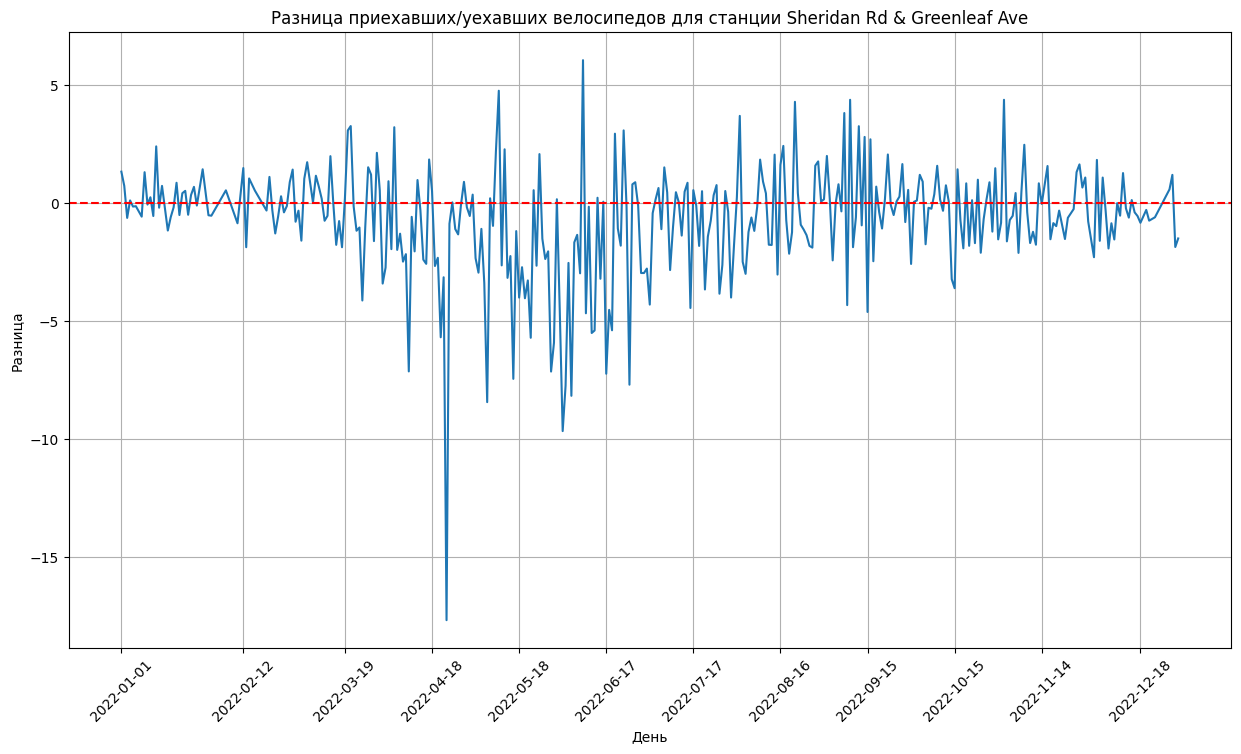

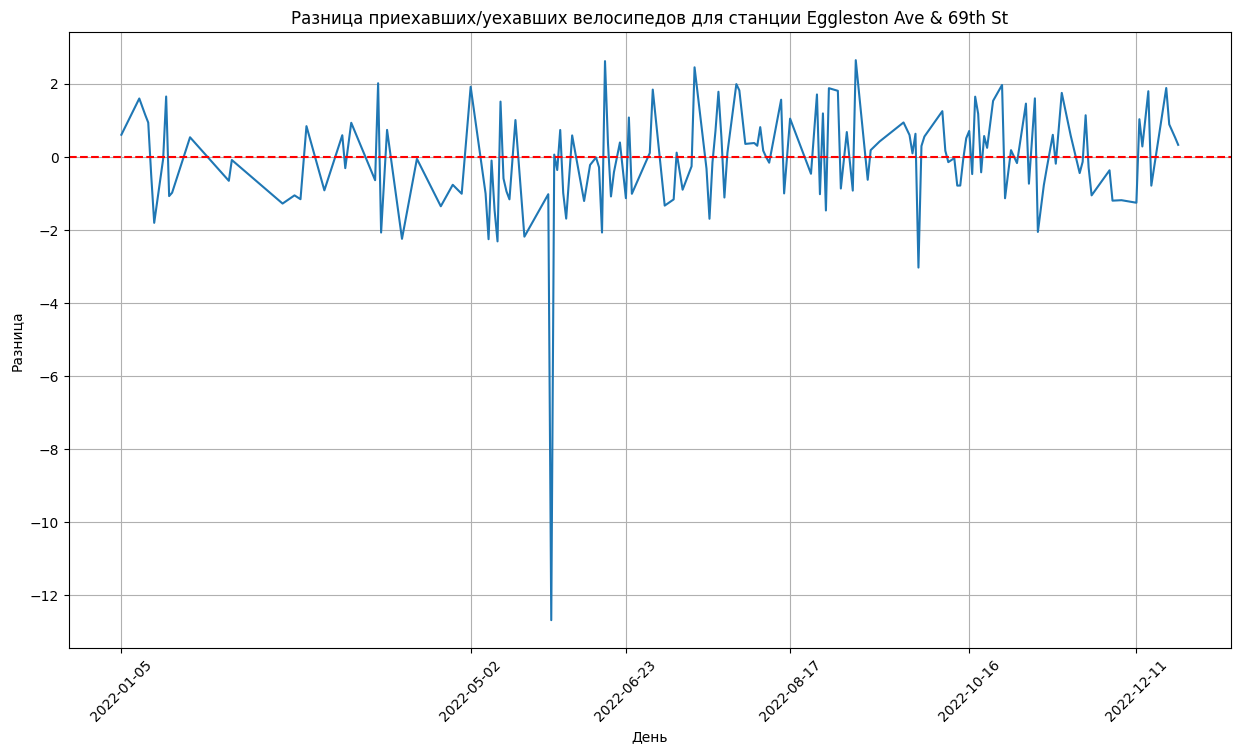

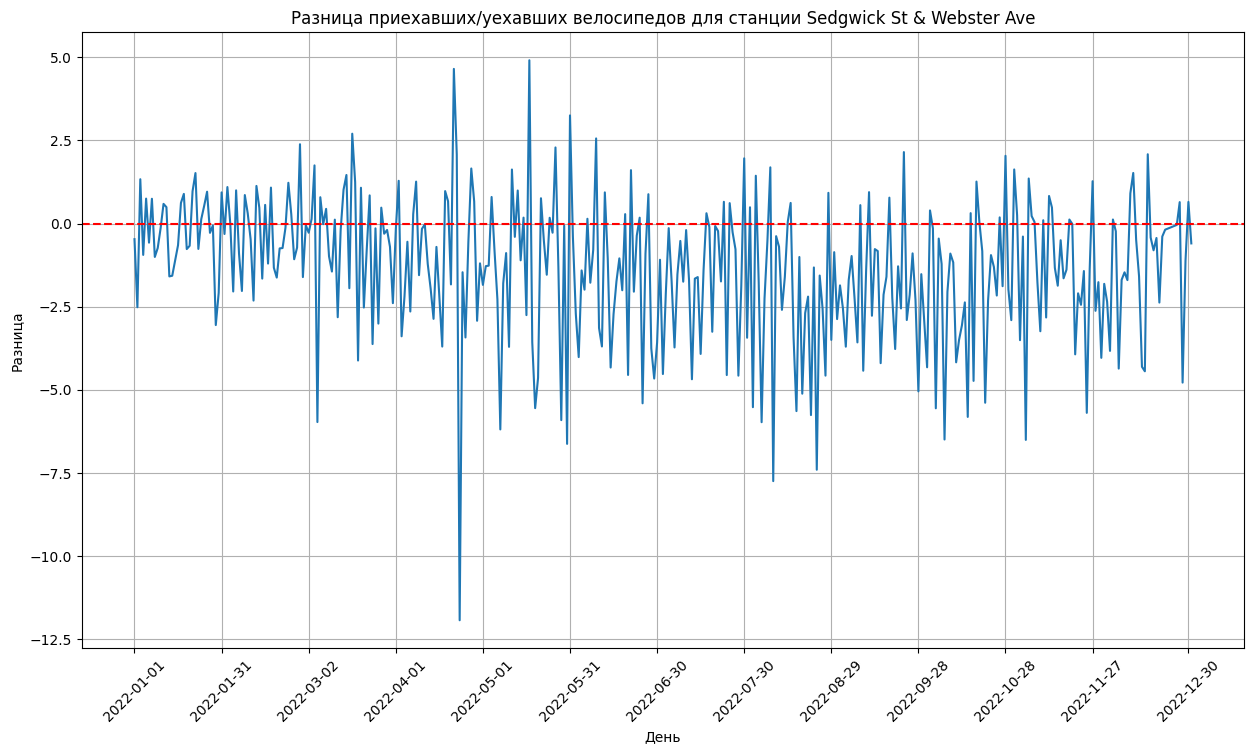

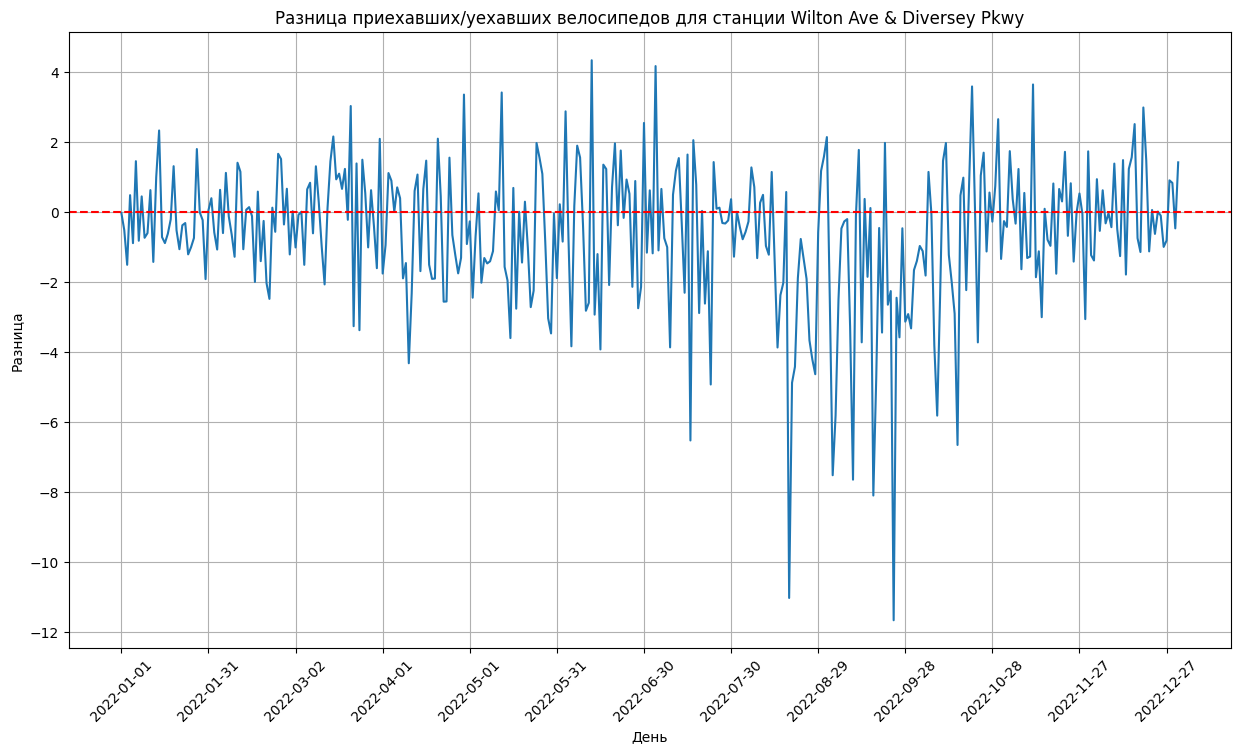

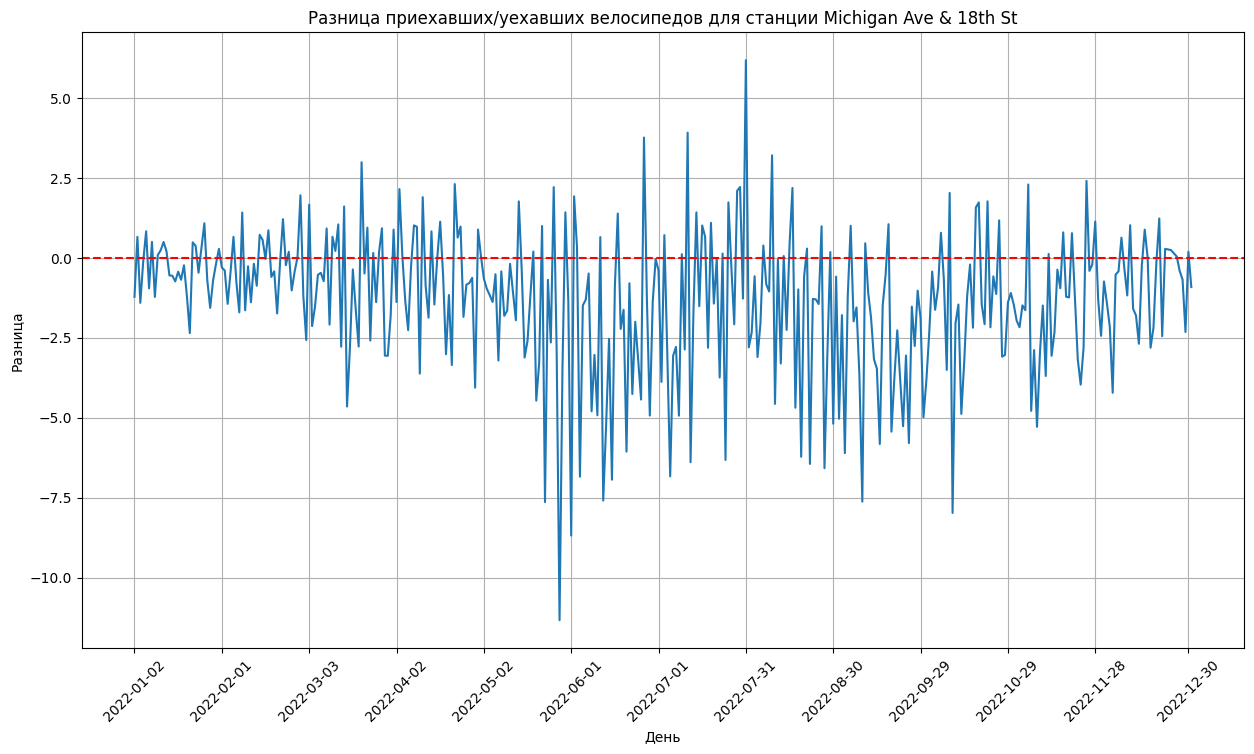

In [219]:
for index in top_5_load.index:
    station = index[0]
    day = index[1]
    station_df = table[(table["station"] == station)]
    fig, ax = plt.subplots(figsize=(15, 8))
    ax.plot(station_df["day"], station_df["difference_smooth"])
    ax.axhline(y=0, color="r", linestyle="--")
    ax.grid(True)
    ax.set_xticks(station_df["day"][::30])
    ax.set_xticklabels(station_df["day"][::30], rotation=45)
    ax.set_title(f"Разница приехавших/уехавших велосипедов для станции {station}")
    ax.set_xlabel("День")
    ax.set_ylabel("Разница")
    plt.show()